# Testing Data Generation

In [13]:
import random
import numpy as np
import json
from tqdm import tqdm
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from scipy.spatial.distance import pdist, squareform
from scipy.optimize import linear_sum_assignment
from collections import Counter
import time
import os
import pandas as pd
from scipy.signal import correlate
np. set_printoptions(threshold=np. inf)

In [4]:
import simulate_data
import scan

In [9]:
def check_ground_truth(pattern_template, K_dense):
    _, pattern_img = get_imgs(K_dense, pattern_template)
    SM_acc, cc = get_acc(K_dense, pattern_img)
    return SM_acc, cc, pattern_img
    

In [10]:
from scipy.signal import correlate
def get_acc(ground_truths,detected_patterns):
    # Calculate cross-correlation matrix
    cross_corr_matrix = np.zeros((ground_truths.shape[2], detected_patterns.shape[2]))
    SM_acc = np.zeros((ground_truths.shape[2]))
    
    if len(detected_patterns) == 0:
        return SM_acc, cross_corr_matrix
    
    for ground_truths_idx in range(ground_truths.shape[2]):
        for detected_patterns_idx in range(detected_patterns.shape[2]):
            cross_corr = np.zeros((ground_truths.shape[1]+detected_patterns.shape[1]-1))
            for n in range(ground_truths.shape[0]):
                cross_corr += correlate(ground_truths[n, :, ground_truths_idx], detected_patterns[n, :, detected_patterns_idx], mode='full')
            max_corr = np.max(cross_corr) / max(np.sum(ground_truths[...,ground_truths_idx]),np.sum(detected_patterns[...,detected_patterns_idx]))
            cross_corr_matrix[ground_truths_idx, detected_patterns_idx] = max_corr
#     print(cross_corr_matrix)
#     print( np.sum(ground_truths[...,ground_truths_idx]))
    SM_acc = np.max(cross_corr_matrix,axis=1)
    return SM_acc, cross_corr_matrix

In [11]:
def get_imgs(K_dense, pattern_template):
    if len(pattern_template) == 0:
        print('FAIL')
        return pattern_template, None
    
    win_size = (K_dense.shape[0],1+max([max(k[:,0]) for k in pattern_template]))
    pattern_img = np.zeros((len(pattern_template),*win_size))
    for p,pattern in enumerate(pattern_template):
        for (i,j) in pattern:
            pattern_img[p,j,i] = 1
            
    pattern_img = pattern_img.transpose((1,2,0))
    
    return pattern_template, pattern_img

In [68]:
N = 40
M = 1
D = 71
T = 1000
seed=0

num_SM_events = 5
SM_total_spikes = 20
noise = 1040

params = {
    'N':N,
    'M':M,
    'D':D,
    'T':T,
    'seed':seed,
    'num_SM_events':num_SM_events,
    'SM_total_spikes':SM_total_spikes,
    'noise':noise
}

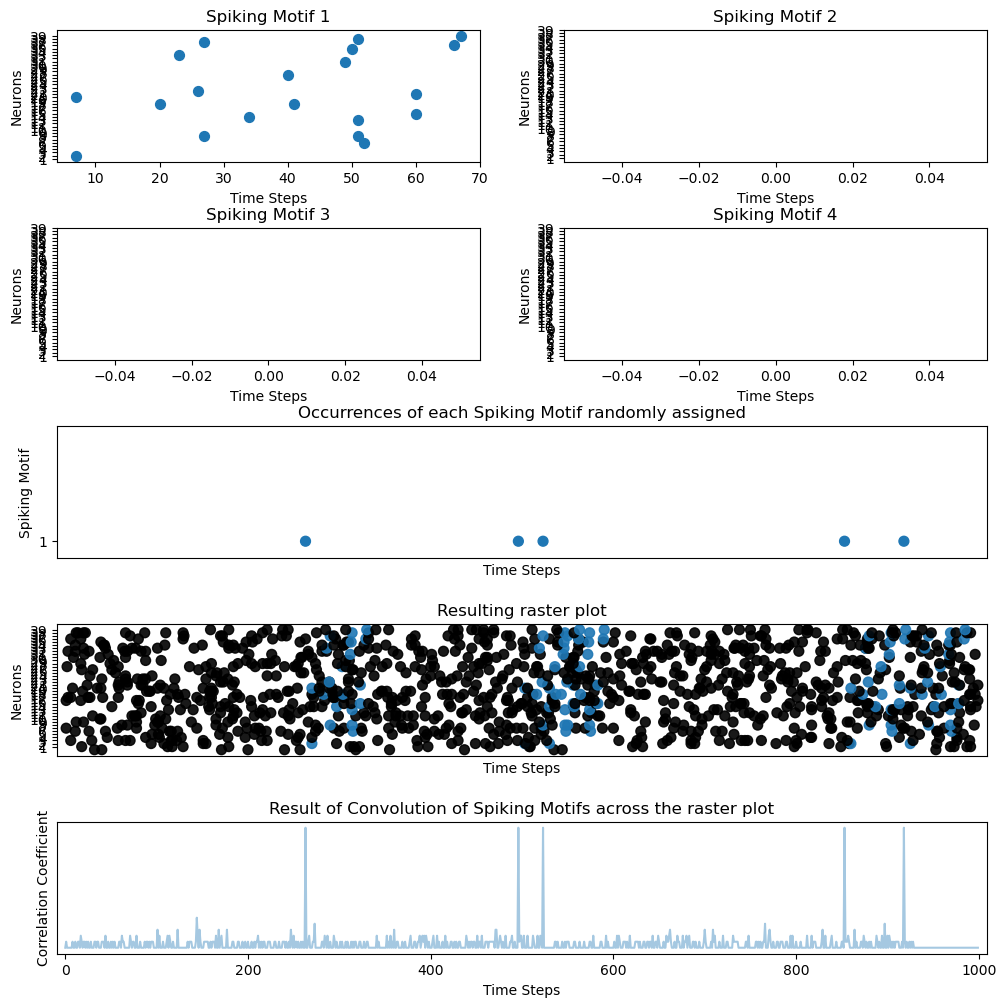

In [69]:
A_dense, A_sparse, B_dense, B_sparse, K_dense, K_sparse = simulate_data.generate_synthetic_data(params,plot=True)

In [70]:
pattern_template, sublist_keys_filt, window_time, cluster_time, sequence_time = scan.scan_raster(A_sparse[1], A_sparse[0], window_dim=params['D'])
if len(pattern_template) != 0:
    SM_acc, cc, pattern_img = check_ground_truth(pattern_template, K_dense)
else:
    SM_acc, cc, pattern_img = np.zeros(K_dense.shape[2]), [], None

1135 Windows
5 patterns found...s... 80% 10.01 | opt_cutoff - 0.26 | most_detections - 4etections - 44_detections - 1


In [71]:
palette = simulate_data.create_palette()

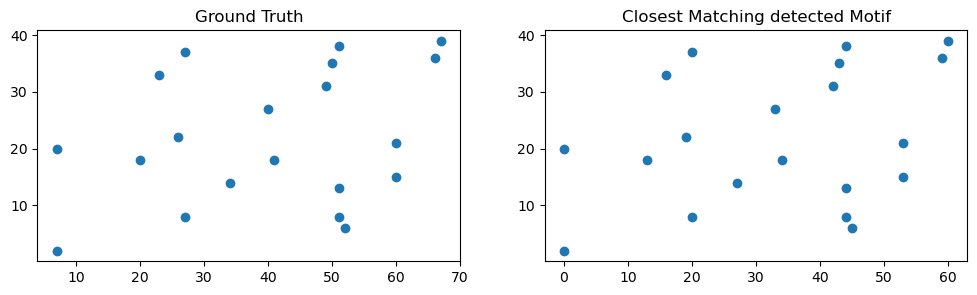

In [72]:
M = K_dense.shape[2]
motif_map = (np.arange(0,M),np.argmax(cc,axis=1))
motif_map
fig,ax = plt.subplots(len(motif_map[0]),len(motif_map),figsize=(12,M*3))
for i,(a,b) in enumerate(zip(motif_map[0],motif_map[1])):
    ax[0].scatter(np.where(K_dense[...,a])[1],np.where(K_dense[...,a])[0],c=palette[i+1])
    ax[1].scatter(np.where(pattern_img[...,b])[1],np.where(pattern_img[...,b])[0],c=palette[i+1])

ax[0].set_title('Ground Truth')
ax[1].set_title('Closest Matching detected Motif')
plt.show()